In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [5]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=15, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - kl_loss: 4.1491 - reconstruction_loss: 388.1565 - total_loss: 392.3056 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - kl_loss: 6.0545 - reconstruction_loss: 265.7809 - total_loss: 271.8353 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - kl_loss: 5.9706 - reconstruction_loss: 261.3740 - total_loss: 267.3445 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 5.9553 - reconstruction_loss: 260.3023 - total_loss: 266.2577 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0384 - reconstruction_loss: 257.7950 - total_loss: 263.83

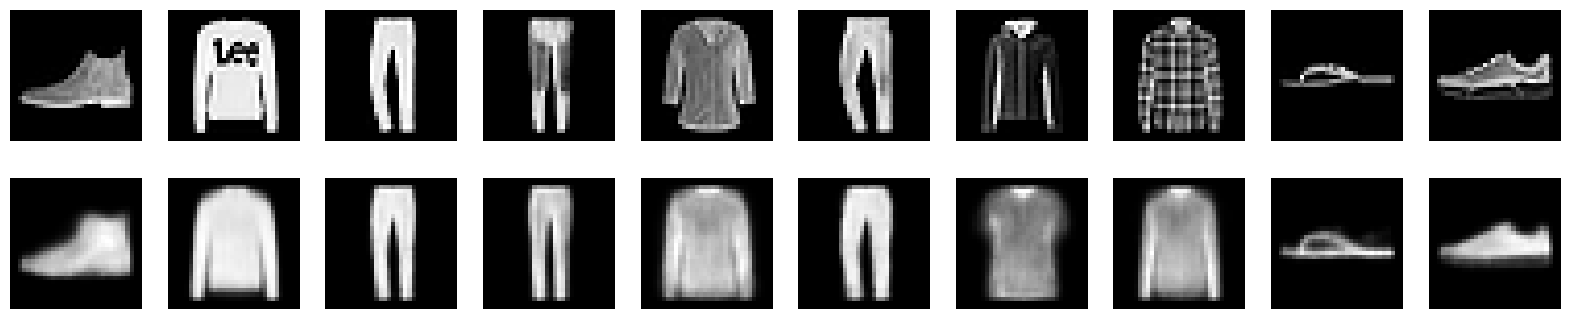

In [6]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


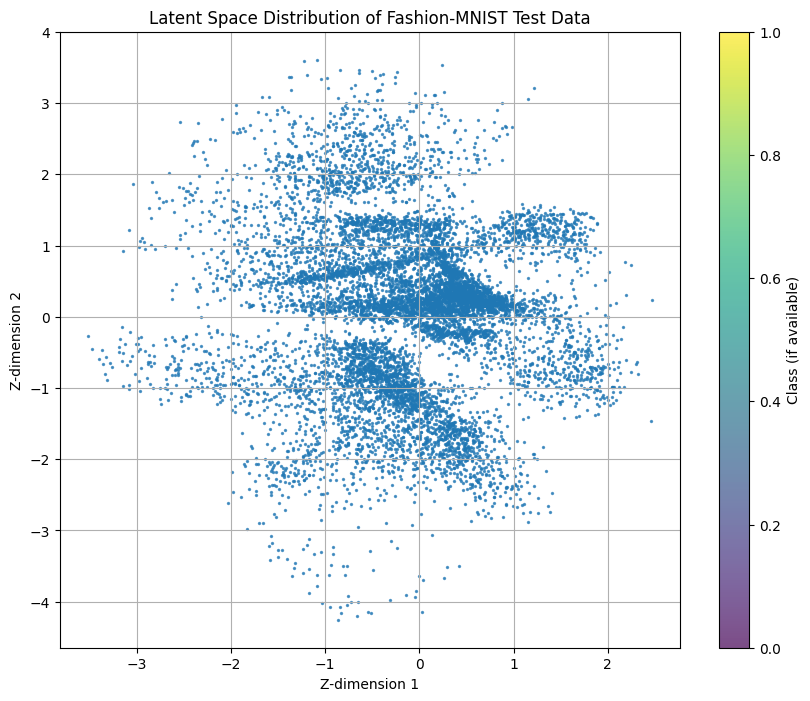

In [7]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_mean, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [8]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [9]:
print("Shape of z_mean:", z_mean.shape)
print("First 5 elements of z_mean:\n", z_mean[:5])

Shape of z_mean: (10000, 2)
First 5 elements of z_mean:
 [[-0.5557194  -1.2014549 ]
 [ 0.5929742   0.21641245]
 [ 0.26102287  2.7158616 ]
 [-0.91475785  1.9952904 ]
 [ 0.02842216 -0.00782713]]


## Visualize Latent Space Distribution by Class



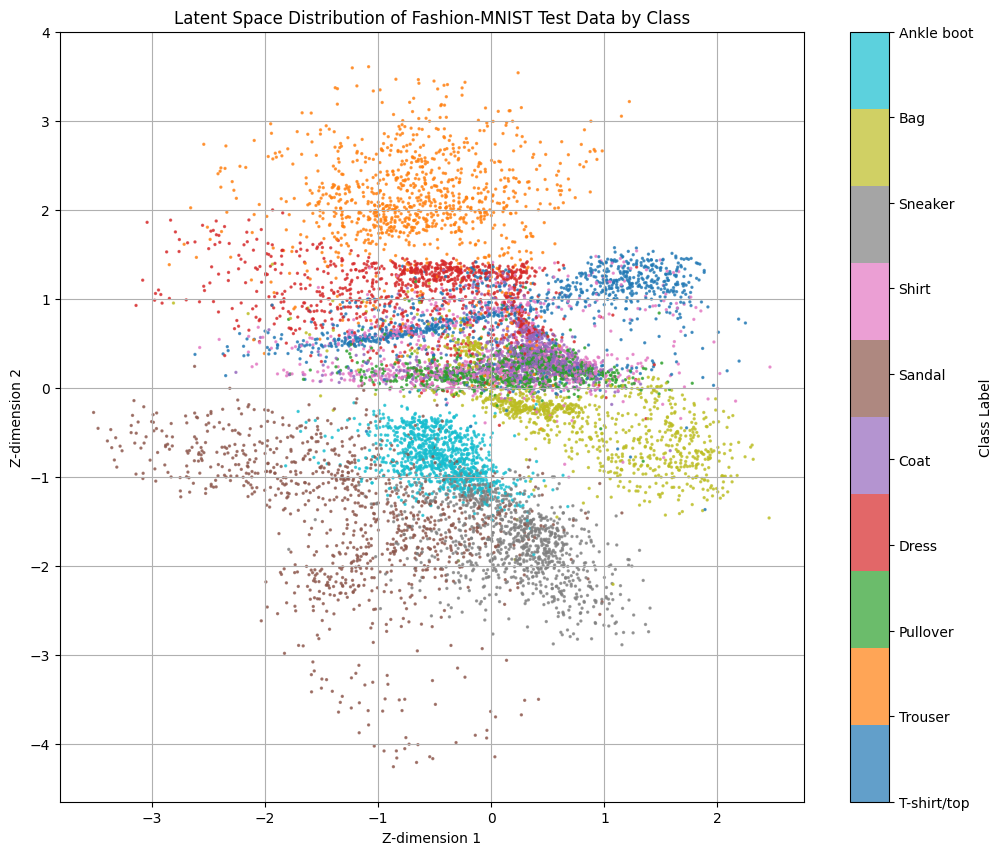

In [10]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

Memulai pelatihan VAE selama 15 epochs...
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - kl_loss: 4.3196 - loss: 367.2462 - reconstruction_loss: 362.9267
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.8397 - loss: 274.7896 - reconstruction_loss: 268.9499
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 5.9383 - loss: 270.0575 - reconstruction_loss: 264.1190
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 5.9868 - loss: 266.8111 - reconstruction_loss: 260.8244
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0492 - loss: 266.0548 - reconstruction_loss: 260.0056
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0882 - loss: 264.3653 - reconstruction_loss: 258.2772
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.1340 - loss: 263.9142 - reconstruction_loss: 257.7802
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.1661 - loss: 263.9271 - reconstruction_loss: 257.7610
Epoc

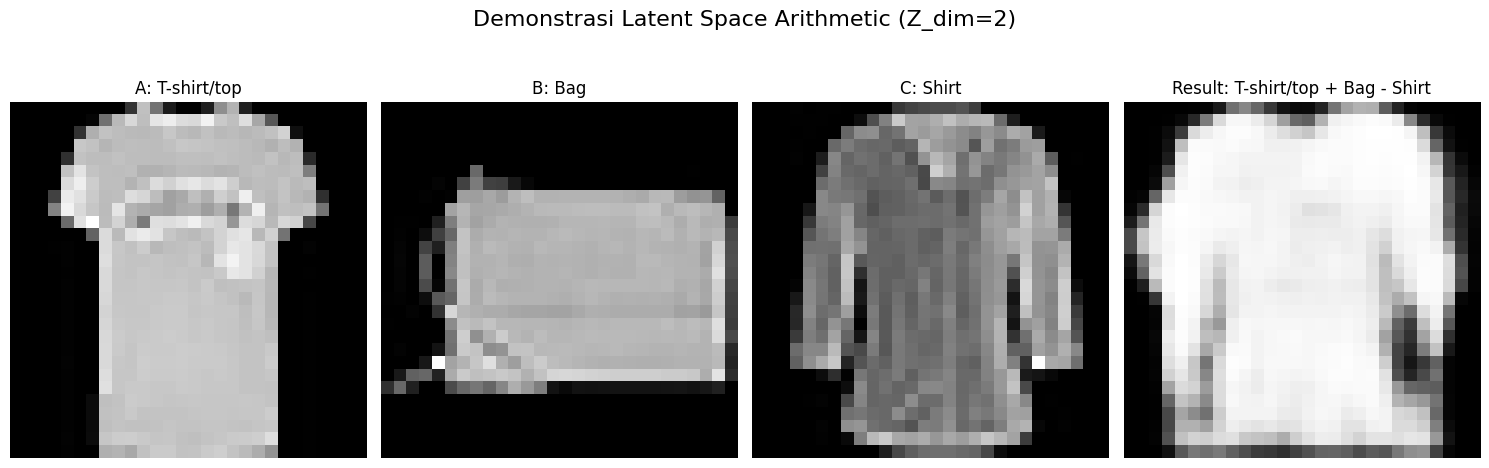


--- Latent Space Arithmetic Operation: Trouser + Sneaker ---


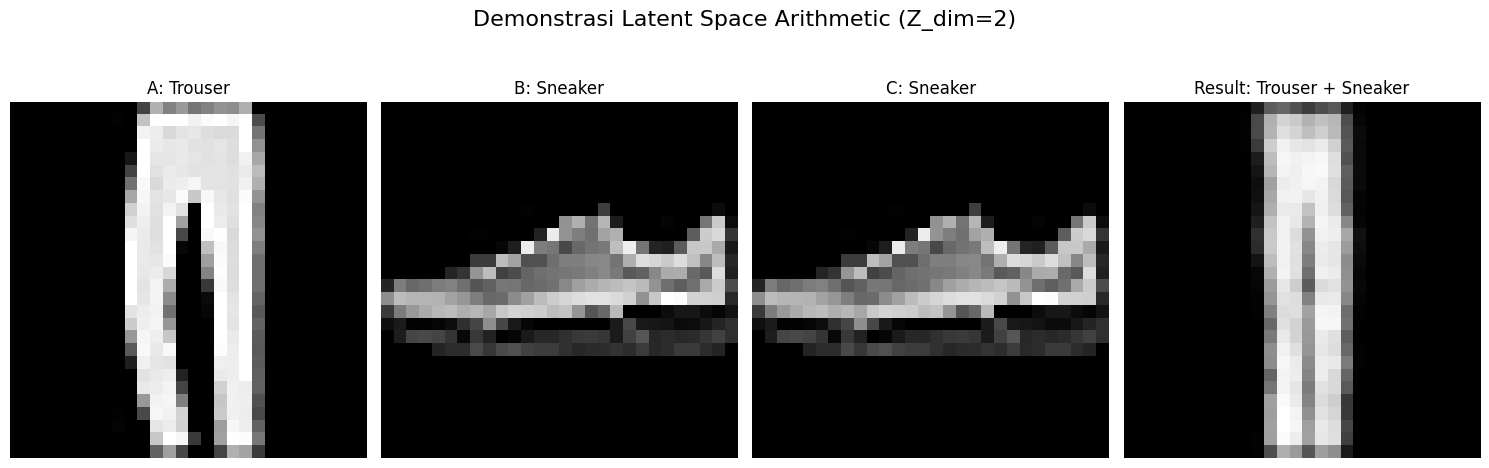



--- Catatan Penting ---
Aritmatika ini dilakukan di ruang laten 2 dimensi.
Karena dimensi yang sangat rendah (Z_DIM=2), hasilnya mungkin terlihat buram atau abstrak.
Instalasi yang dibutuhkan: pip install tensorflow matplotlib numpy


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# --- Konfigurasi dan Hyperparameter ---
IMAGE_SIZE = 28
BATCH_SIZE = 128
Z_DIM = 2  # Latent space dimension (used 2D for easier visualization)
EPOCHS = 15  # Training epochs (adjusted to 15)

# Fashion MNIST Labels for visual identification
LABELS = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# --- Memuat dan Mempersiapkan Data ---
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and reshape images to (28, 28, 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# --- 1. Model VAE (Variational Autoencoder) ---

# --- 1.1. Encoder ---
def create_encoder(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), z_dim=Z_DIM):
    """Creates the Encoder model to map images to the latent space."""
    input_img = layers.Input(shape=input_shape, name='encoder_input')

    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(input_img)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Encoder output: mean (z_mu) and log-variance (z_log_var)
    z_mu = layers.Dense(z_dim, name='z_mean')(x)
    z_log_var = layers.Dense(z_dim, name='z_log_var')(x)

    # Reparameterization trick for sampling
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    # Latent space vector (z)
    z = layers.Lambda(sampling, output_shape=(z_dim,), name='z')([z_mu, z_log_var])

    return Model(input_img, [z_mu, z_log_var, z], name='encoder')

# --- 1.2. Decoder ---
def create_decoder(z_dim=Z_DIM, output_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)):
    """Creates the Decoder model to map a latent vector back to an image."""
    latent_input = layers.Input(shape=(z_dim,), name='latent_input')

    # Initial dense layer before upsampling
    decoder_dense = layers.Dense(7 * 7 * 64, activation='relu')(latent_input)
    x = layers.Reshape((7, 7, 64))(decoder_dense)

    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    # Final output layer uses sigmoid activation
    decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    return Model(latent_input, decoder_output, name='decoder')

# --- 1.3. VAE Model Class (Custom Training Step) ---
class VAE(Model):
    """VAE class that includes the custom VAE loss function (Reconstruction + KL Divergence)."""
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Metrics to track losses
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # 1. Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # 2. Reconstruction Loss (Binary Cross-Entropy for 0-1 normalized images)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # 3. KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss
            total_loss = reconstruction_loss + kl_loss

        # 4. Apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # 5. Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# --- 2. Initialization and Training ---
encoder = create_encoder()
decoder = create_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("Memulai pelatihan VAE selama {} epochs...".format(EPOCHS))
vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
print("Pelatihan selesai.")

# --- 3. Latent Space Arithmetic Functions ---

def encode_image(image):
    """Compresses an image into the mean vector (z_mu) in the latent space."""
    # Add batch dimension
    image = np.expand_dims(image, 0)
    z_mean, _, _ = vae.encoder.predict(image, verbose=0)
    return z_mean[0] # Return latent vector (without batch dimension)

def decode_latent_vector(z_vector):
    """Decodes a latent vector back into an image."""
    # Add batch dimension
    z_vector = np.expand_dims(z_vector, 0)
    decoded_img = vae.decoder.predict(z_vector, verbose=0)
    # Remove batch and channel dimensions (28x28x1 -> 28x28)
    return decoded_img[0, :, :, 0]


def perform_latent_arithmetic(img_a, img_b, img_c, weight_b=1.0, weight_c=-1.0, title="A + B - C"):
    """
    Performs arithmetic operation in the latent space:
    Z_result = Z_A + (Z_B * weight_b) + (Z_C * weight_c)
    """

    # 1. Encoding (get latent vectors)
    z_a = encode_image(img_a)
    z_b = encode_image(img_b)
    z_c = encode_image(img_c)

    # Get labels for plotting (using the globally set indices for simplicity)
    label_a_idx = y_test[img_a_idx].item() if isinstance(y_test[img_a_idx], np.ndarray) else y_test[img_a_idx]
    label_b_idx = y_test[img_b_idx].item() if isinstance(y_test[img_b_idx], np.ndarray) else y_test[img_b_idx]
    label_c_idx = y_test[img_c_idx].item() if isinstance(y_test[img_c_idx], np.ndarray) else y_test[img_c_idx]

    print(f"\n--- Latent Space Arithmetic Operation: {title} ---")

    # 2. Vector Arithmetic
    z_result = z_a + (z_b * weight_b) + (z_c * weight_c)

    # 3. Decoding (get resulting image)
    img_result = decode_latent_vector(z_result)

    # --- Visualization ---
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Image A (Base)
    axes[0].imshow(x_test[img_a_idx][:, :, 0], cmap='gray')
    axes[0].set_title(f"A: {LABELS[label_a_idx]}")
    axes[0].axis('off')

    # Image B (Addition)
    axes[1].imshow(x_test[img_b_idx][:, :, 0], cmap='gray')
    axes[1].set_title(f"B: {LABELS[label_b_idx]}")
    axes[1].axis('off')

    # Image C (Subtraction)
    axes[2].imshow(x_test[img_c_idx][:, :, 0], cmap='gray')
    axes[2].set_title(f"C: {LABELS[label_c_idx]}")
    axes[2].axis('off')

    # Resulting Image
    axes[3].imshow(img_result, cmap='gray')
    axes[3].set_title(f"Result: {title}")
    axes[3].axis('off')

    fig.suptitle(f"Demonstrasi Latent Space Arithmetic (Z_dim={Z_DIM})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return z_result, img_result


# --- 4. Performing Arithmetic Experiments ---

def find_image_index_by_label(label_index, dataset_y, max_count=5):
    """Finds image indices based on the class label."""
    indices = np.where(dataset_y == label_index)[0]
    return indices[:max_count].tolist()

# Label numbers: T-shirt/top=0, Trouser=1, Pullover=2, Dress=3, Coat=4,
# Sandal=5, Shirt=6, Sneaker=7, Bag=8, Ankle boot=9

# Example 1: T-shirt - Shirt + Bag
# Goal: Get a T-shirt, remove the 'shirt' feature (sleeves/collar), add the 'bag' feature (texture/shape).

indices_tshirt = find_image_index_by_label(0, y_test)
indices_shirt = find_image_index_by_label(6, y_test)
indices_bag = find_image_index_by_label(8, y_test)

if not indices_tshirt or not indices_shirt or not indices_bag:
    print("Could not find required image indices.")
else:
    # Select one index from each category
    img_a_idx = indices_tshirt[0] # T-shirt (Base)
    img_b_idx = indices_bag[0]    # Bag (Feature to add)
    img_c_idx = indices_shirt[0]  # Shirt (Feature to subtract)

    img_a = x_test[img_a_idx]
    img_b = x_test[img_b_idx]
    img_c = x_test[img_c_idx]

    # Perform Arithmetic
    perform_latent_arithmetic(
        img_a=img_a,
        img_b=img_b,
        img_c=img_c,
        weight_b=1.0,
        weight_c=1.0,   # Use 1.0 for subtraction as the default function uses -1.0
        title=f"{LABELS[0]} + {LABELS[8]} - {LABELS[6]}" # T-shirt + Bag - Shirt
    )

    # Example 2: Trouser + Sneaker (Just addition, ignoring the third term)
    indices_trouser = find_image_index_by_label(1, y_test)
    indices_sneaker = find_image_index_by_label(7, y_test)

    if indices_trouser and indices_sneaker:
        img_d_idx = indices_trouser[0]
        img_e_idx = indices_sneaker[0]

        img_d = x_test[img_d_idx]
        img_e = x_test[img_e_idx]

        # Update global indices for plotting
        img_a_idx = img_d_idx
        img_b_idx = img_e_idx
        img_c_idx = img_e_idx # Use placeholder image, will be multiplied by weight_c=0.0

        perform_latent_arithmetic(
            img_a=img_d,
            img_b=img_e,
            img_c=img_e,
            weight_b=1.0,
            weight_c=0.0, # No subtraction
            title=f"{LABELS[1]} + {LABELS[7]}"
        )
    else:
        print("Indices for Trouser or Sneaker not found.")

    print("\n\n--- Catatan Penting ---")
    print(f"Aritmatika ini dilakukan di ruang laten {Z_DIM} dimensi.")
    print("Karena dimensi yang sangat rendah (Z_DIM=2), hasilnya mungkin terlihat buram atau abstrak.")
    print("Instalasi yang dibutuhkan: pip install tensorflow matplotlib numpy")

Memuat dan mempersiapkan data Fashion MNIST...

--- Melatih Autoencoder (AE) ---
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 356.0223
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 270.5743
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 265.6955
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 263.5573
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 261.7439
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 260.8188
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 260.3315
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 258.8527
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 258.5668
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 258.1689
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 257.7416
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 257.5145
Epoch 13/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 257.0155
Epoch 14/15
469/46

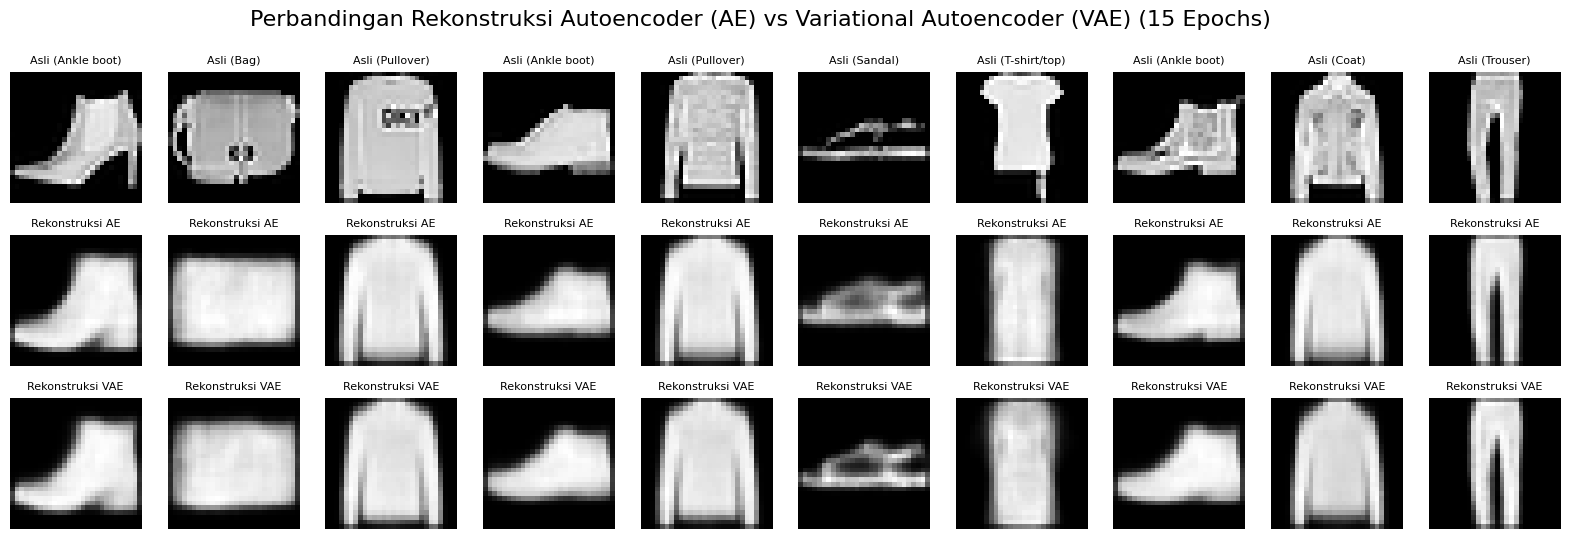


--- Plotting Ruang Laten VAE (2D) ---


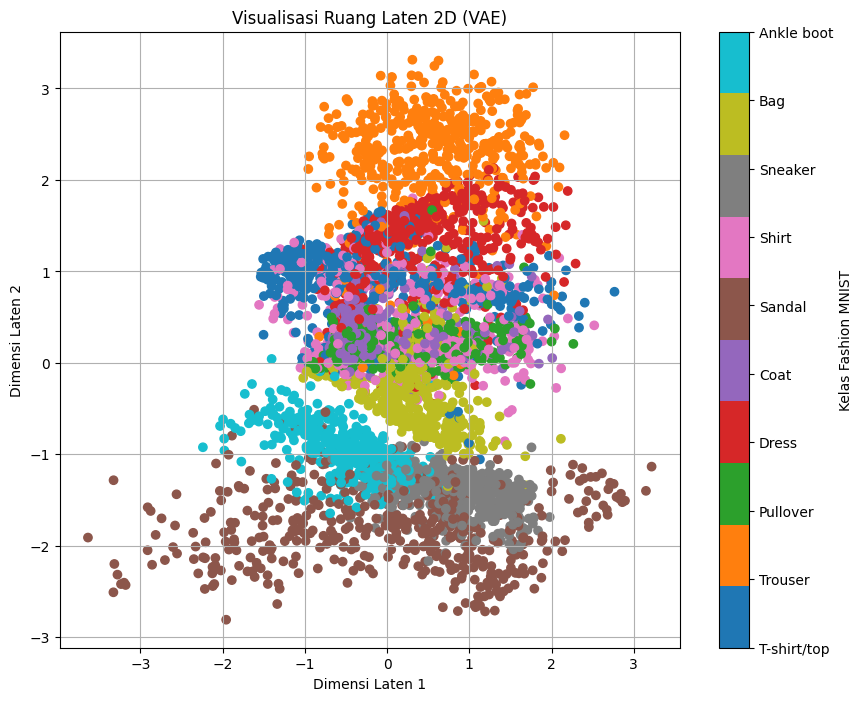

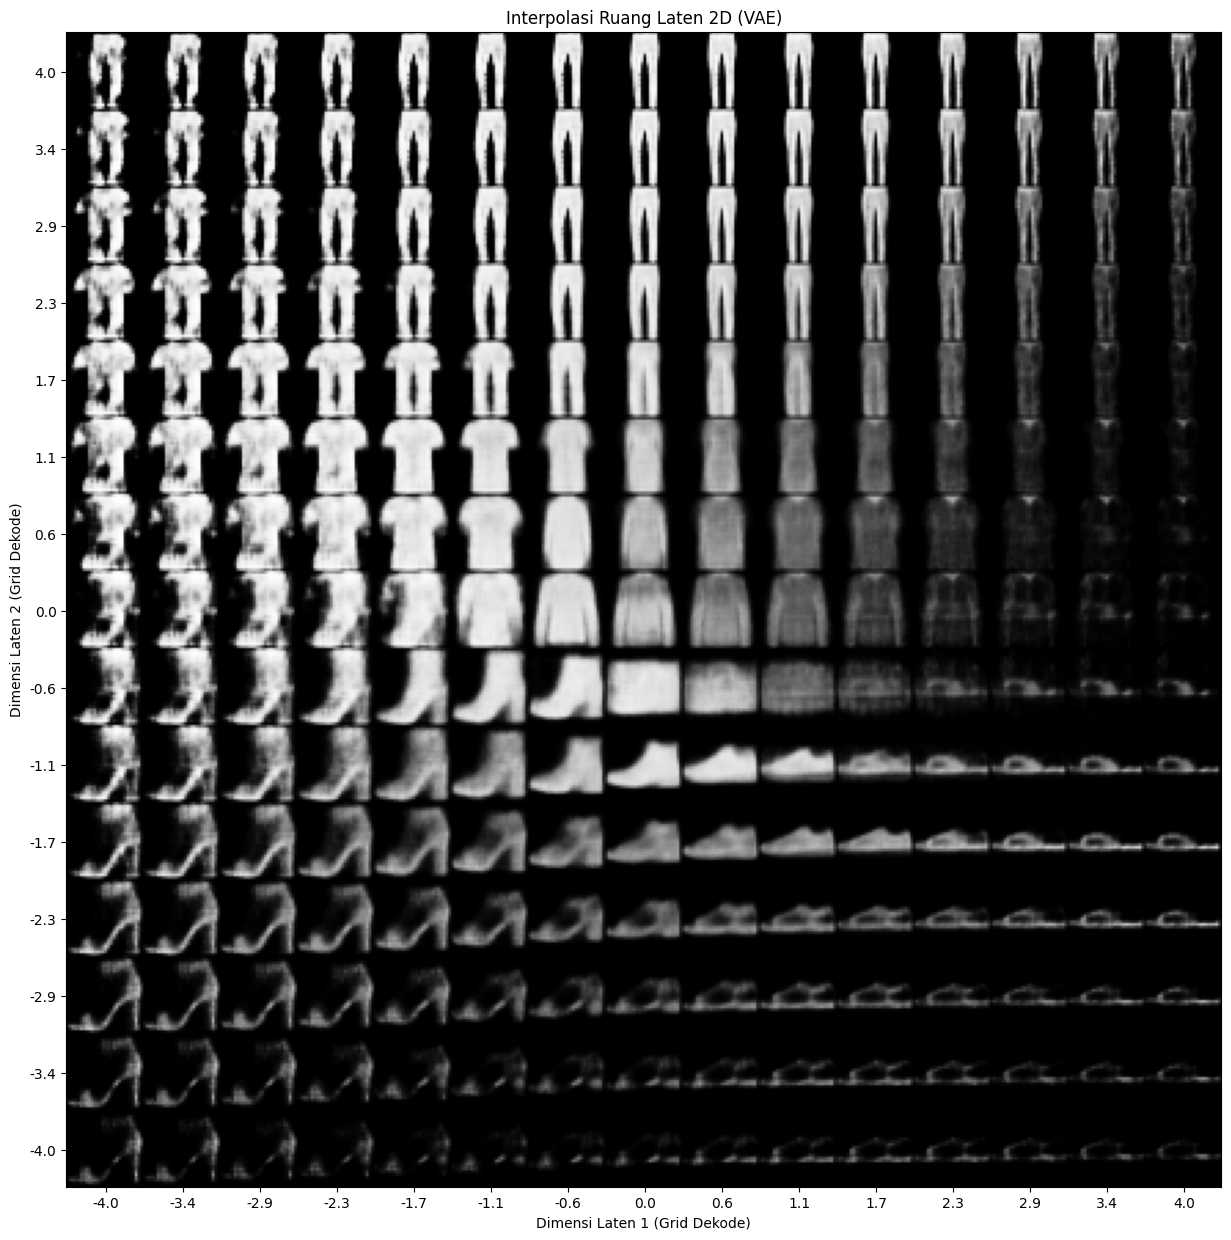



Instalasi yang dibutuhkan: pip install tensorflow matplotlib numpy


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, ops, losses, metrics
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# --- 0. Konfigurasi dan Hyperparameter ---
IMAGE_SIZE = 28
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
BATCH_SIZE = 128
Z_DIM = 2     # Dimensi ruang laten (tetap 2D untuk visualisasi sederhana)
MODEL_EPOCHS = 15 # Epochs pelatihan

# Label Fashion MNIST
LABELS = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# --- 1. Memuat dan Mempersiapkan Data ---
print("Memuat dan mempersiapkan data Fashion MNIST...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisasi dan reshape (28x28x1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# --- Helper Functions and Custom Layers ---

# Define the Sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = keras.random.normal(ops.shape(z_mean))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

# Define build_encoder_core function
def build_encoder_core(input_shape=INPUT_SHAPE):
    """Membangun bagian inti dari Encoder."""
    input_img = layers.Input(shape=input_shape, name='encoder_input')
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(input_img)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    flattened_output = layers.Flatten()(x)
    return models.Model(inputs=input_img, outputs=flattened_output, name='encoder_core')

# Define build_decoder_model function
def build_decoder_model(z_dim=Z_DIM):
    """Membangun model Decoder."""
    latent_input = layers.Input(shape=(z_dim,), name='latent_input')
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_input)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_input, decoder_output, name='decoder')


# --- 4. Autoencoder Biasa (AE) ---
# Define AutoEncoder class
class AutoEncoder(models.Model):
    def __init__(self, encoder_core_model, decoder_model, z_dim=Z_DIM, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder_core = encoder_core_model
        self.latent_layer = layers.Dense(z_dim, name='latent_vector')
        self.decoder = decoder_model
        self.total_loss_tracker = metrics.Mean(name="total_loss")

    def call(self, inputs):
        core_output = self.encoder_core(inputs)
        z = self.latent_layer(core_output)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [self.total_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstruction = self(data) # Forward pass
            reconstruction_loss = ops.mean(
                ops.sum(losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            total_loss = reconstruction_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}


# --- 5. Variational Autoencoder (VAE) ---
# Define VAE class
class VAE(models.Model):
    def __init__(self, encoder_core_model, decoder_model, z_dim=Z_DIM, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder_core = encoder_core_model
        self.z_mean_layer = layers.Dense(z_dim, name="z_mean")
        self.z_log_var_layer = layers.Dense(z_dim, name="z_log_var")
        self.sampling_layer = Sampling()
        self.decoder = decoder_model

        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    def call(self, inputs):
        core_output = self.encoder_core(inputs)
        z_mean = self.z_mean_layer(core_output)
        z_log_var = self.z_log_var_layer(core_output)
        z = self.sampling_layer([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data) # Forward pass

            # Reconstruction loss
            reconstruction_loss = ops.mean(
                ops.sum(losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )

            # KL divergence loss
            kl_loss = -0.5 * ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=1)
            kl_loss = ops.mean(kl_loss)

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# --- 6. Inisialisasi dan Pelatihan ---

# --- AE ---
# Build encoder core that will be shared
encoder_core_model_ae = build_encoder_core(input_shape=INPUT_SHAPE)

# Build decoder
decoder_ae = build_decoder_model(z_dim=Z_DIM)

# Instantiate AutoEncoder
ae_model = AutoEncoder(encoder_core_model_ae, decoder_ae, z_dim=Z_DIM)
ae_model.compile(optimizer=keras.optimizers.Adam())

print("\n--- Melatih Autoencoder (AE) ---")
ae_model.fit(x_train, epochs=MODEL_EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

# Create a separate AE encoder for prediction/visualization
# This encoder maps input_ae to the latent vector z
input_ae_for_encoder = keras.Input(shape=INPUT_SHAPE)
z_ae = ae_model.latent_layer(encoder_core_model_ae(input_ae_for_encoder))
ae_encoder = models.Model(input_ae_for_encoder, z_ae, name='ae_encoder')

# --- VAE ---
# Build encoder core that will be shared
encoder_core_model_vae = build_encoder_core(input_shape=INPUT_SHAPE)

# Build decoder
decoder_vae = build_decoder_model(z_dim=Z_DIM)

# Instantiate VAE
vae_model = VAE(encoder_core_model_vae, decoder_vae, z_dim=Z_DIM)
vae_model.compile(optimizer=keras.optimizers.Adam())

print("\n--- Melatih Variational Autoencoder (VAE) ---")
vae_model.fit(x_train, epochs=MODEL_EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

# Create a separate VAE encoder for prediction/visualization
# This encoder outputs z_mean, z_log_var, z
input_vae_for_encoder = keras.Input(shape=INPUT_SHAPE)
z_mean_vae = vae_model.z_mean_layer(encoder_core_model_vae(input_vae_for_encoder))
z_log_var_vae = vae_model.z_log_var_layer(encoder_core_model_vae(input_vae_for_encoder))
z_vae = vae_model.sampling_layer([z_mean_vae, z_log_var_vae])
vae_encoder = models.Model(input_vae_for_encoder, [z_mean_vae, z_log_var_vae, z_vae], name='vae_encoder')

print("Pelatihan kedua model selesai.")


# --- 7. Visualisasi Perbandingan Rekonstruksi ---

def plot_reconstructions(n=10):
    """Plot perbandingan antara gambar asli, rekonstruksi AE, dan rekonstruksi VAE."""

    # Ambil sampel n gambar dari test set
    indices = np.random.choice(len(x_test), n, replace=False)
    original_images = x_test[indices]

    # Rekonstruksi AE
    ae_reconstructed = ae_model.predict(original_images, verbose=0)

    # Rekonstruksi VAE
    # Untuk VAE, kita biasanya menggunakan z_mean dari encoder untuk rekonstruksi yang stabil
    z_mean_pred, _, _ = vae_encoder.predict(original_images, verbose=0) # Use vae_encoder that returns z_mean
    vae_reconstructed = decoder_vae.predict(z_mean_pred, verbose=0) # Use decoder_vae

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Gambar Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Asli ({LABELS[y_test[indices[i]]]})", fontsize=8)
        plt.axis("off")

        # Rekonstruksi AE
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(ae_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Rekonstruksi AE", fontsize=8)
        plt.axis("off")

        # Rekonstruksi VAE
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(vae_reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Rekonstruksi VAE", fontsize=8)
        plt.axis("off")

    plt.suptitle(f"Perbandingan Rekonstruksi Autoencoder (AE) vs Variational Autoencoder (VAE) ({MODEL_EPOCHS} Epochs)", fontsize=16)
    plt.show()

# Adjust plot_latent_space_2d
def plot_latent_space_2d(encoder_model, decoder_model, x_data, y_data, model_name="VAE"):
    """Visualisasi 2D ruang laten (hanya berlaku untuk VAE karena VAE_encoder memberikan z_mean)."""
    # Menggunakan Encoder VAE untuk visualisasi. encoder_model should be vae_encoder
    z_mean, _, _ = encoder_model.predict(x_data, verbose=0)
    plt.figure(figsize=(10, 8))

    # Scatter plot titik laten
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_data, cmap='tab10')
    plt.colorbar(scatter, ticks=range(10), label='Kelas Fashion MNIST', format=plt.FuncFormatter(lambda i, *args: LABELS[int(i)]))
    plt.xlabel("Dimensi Laten 1")
    plt.ylabel("Dimensi Laten 2")
    plt.title(f"Visualisasi Ruang Laten 2D ({model_name})")
    plt.grid(True)
    plt.show()

    # Plot grid dari gambar yang dihasilkan
    n = 15  # Jumlah titik grid
    figure = np.zeros((IMAGE_SIZE * n, IMAGE_SIZE * n))
    grid_x = np.linspace(-4, 4, n) # Asumsi distribusi N(0, 1) untuk VAE
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder_model.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(IMAGE_SIZE, IMAGE_SIZE)
            figure[i * IMAGE_SIZE: (i + 1) * IMAGE_SIZE,
                   j * IMAGE_SIZE: (j + 1) * IMAGE_SIZE] = digit

    plt.figure(figsize=(15, 15))
    start_range = IMAGE_SIZE // 2
    # Fix: remove the '+ 1' from end_range to make pixel_range have 'n' elements
    end_range = n * IMAGE_SIZE + start_range
    pixel_range = np.arange(start_range, end_range, IMAGE_SIZE)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Dimensi Laten 1 (Grid Dekode)")
    plt.ylabel("Dimensi Laten 2 (Grid Dekode)")
    plt.imshow(figure, cmap='Greys_r')
    plt.title(f"Interpolasi Ruang Laten 2D ({model_name})")
    plt.show()


# --- 8. Eksekusi Visualisasi ---
print("\n--- Plotting Hasil Rekonstruksi ---")
plot_reconstructions(n=10)

print("\n--- Plotting Ruang Laten VAE (2D) ---")
# Catatan: Visualisasi Ruang Laten hanya masuk akal untuk VAE karena VAE
# mendorong distribusi laten ke Gaussian (membuat ruang laten \"kontinu\").
plot_latent_space_2d(vae_encoder, decoder_vae, x_test[:5000], y_test[:5000], model_name="VAE")

print("\n\nInstalasi yang dibutuhkan: pip install tensorflow matplotlib numpy")